# Training a CNN with Pytorch
We will now be using a expanded version of the digits data set to train a convolutional neural network.

We will again be using the Pytorch library. As you will have seen from the previous notebook, in comparison to sklearn, Pytorch provides much more control over the architecture of your neural network. We will be making use of this here.

As before, we load the libraries that we need:

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

The next lines check if your computer has CUDA GPU capabilities and uses it if it can. The lab computires fon't have GPUs. This means that the model will still train, but it will be slower than it could be. Everything should still run within a minute or two.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Import some data
Like sklearn, PyTorch has some built in datasets. We will be using the MNIST digits data set, which is a larger version (in both image size and image quantity) of the sklearn digits dataset. Note that the code snippet below creates two dataset objects, one which is training data (train = True) and the other that is test data.

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
    )
    
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
    )

## View basic data set information
Now that the dataset has been imported, you can view information about the train/test set using print(train_data) if you wish. You will see that there are 60000 training examples and 10000 test examples

In [5]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Like the Sklearn task, let's plot one of the images to see what we're looking at. Note that these are grayscale images (i.e. different shades of grey) rather than full RGB colour images.

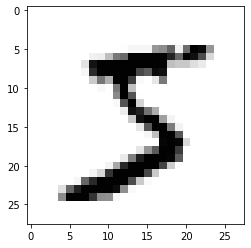

In [6]:
plt.imshow(train_data.data[0], cmap='Greys')
plt.show()

# Create the convolutional neural network architecture as a new class, CNN

The CNN class below creates the neural network architecture. This structure is a little bit more complicated than the multi-layer perceptron. In particular, we now incorporate convolution and maxpooling layers. These are built-in to Pytorch, so we do not need to define them from scratch.

For ease of reading, we group sets of neural network operations (layers) together via the nn.sequential function. So, *conv1* consists of a conv2d layer, a ReLU activation and a max pooling layer. Each layer type has its own parameters (in_channels, out_channels, etc.)

In conv1, the convolution (conv2d) layer, we create 16 convolution filters (out_channels), a free choice by us. 

In the 2nd set of convolutions, defined by *conv2*, we have 16 convolutions from *conv1*, so our first parameter is 16 and we choose to have 32 output filters. Note that, for *conv2*, the parameters have been written in shorthand, without explicitly referring to the parameter variable name.

The function, forward, describes how the whole network is put together from its component layers. It shows how we first put our input through *conv1*, then *conv2*, then *out* (a fully connected layer). 

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=8,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(8, 16, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(16 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

## instantiate the neural network object
The class code above describes what our CNN object looks like, but we need to actual create an instance of the object. We do a similar thing when we train models in sklearn

In [24]:
cnn = CNN() # note that the variable name can be anything here, but I've chosen cnn for clarity

# Define the loss function and optimizer 
We now define the loss function and optimizer to train the network. Unlike standard stochastic gradient descent (what we looked at in the lectures), Adam is a variant that uses an adaptive learning rate to allow for faster convergence in many situations.

We set the initial learning rate at 0.01. This is quite large and may lead to non-convergence in other problems, but in this case I know it works (through trial and error), and it means that we will be abel to see the impact of training in relatively few iterations

We use the cross entropy loss, which is the go-to for classification problems, rather than something like the mean squared error.

In [25]:
loss_func = nn.CrossEntropyLoss()   
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.005)

# Set up training parameters

When we used Pytorch in the previous notebook, we used all of the data (i.e. full gradient descent). However, Pytorch gives us the ability to perform gradient descent, using a pre-specified batch size. This is taken care of by the dataloader utility

the *batch_size* sets the mini-batch used in SGD (i.e. how many examples are considered at each step - in the lectures, we consider one example at a time, so-called online SGD). *shuffle* shuffles the data at each epoch, to reduce the likelihood of weird local convergence. This might happen, for instance, if all of the digits are in order, so that all of the 1s are trained first. This could lead to a situation where the network thinks that it has finished training because it sees thousands of examples of 1s, and only trains to recognise 1s. *num_workers* relates to how the data is handled in the memory (e.g. whether there are multiple sub-processes)

In [26]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=2),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=2),
}

## training function
We now define how model training works, over num_epochs. Note how the loss is computed. Gradients are computed useing loss.backward, and then weights are updated using optimizer.step()

In [27]:
num_epochs = 2
def train(num_epochs, cnn, loaders):
    
    # this sets the model mode - (i.e. layers like dropout, batchnorm etc behave differently during training compared to testing)
    # note that this function was not defined explicitly in CNN, but because CNN is a type of nn.Module, it inherits some functions
    # from the more general nn class.
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
       
            b_x = images
            b_y = labels
            
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass     
        pass
    pass

After you have run everything above, call the training function below.

In [28]:
train(num_epochs, cnn, loaders)

Epoch [1/2], Step [100/600], Loss: 0.1035
Epoch [1/2], Step [200/600], Loss: 0.1141
Epoch [1/2], Step [300/600], Loss: 0.1043
Epoch [1/2], Step [400/600], Loss: 0.0720
Epoch [1/2], Step [500/600], Loss: 0.0762
Epoch [1/2], Step [600/600], Loss: 0.0503
Epoch [2/2], Step [100/600], Loss: 0.0832
Epoch [2/2], Step [200/600], Loss: 0.0460
Epoch [2/2], Step [300/600], Loss: 0.1262
Epoch [2/2], Step [400/600], Loss: 0.0066
Epoch [2/2], Step [500/600], Loss: 0.0134
Epoch [2/2], Step [600/600], Loss: 0.0786


# Test the model
In a standard gradient descent, you would expect the training loss to go down consistently. However, we are estimating the gradient each time on a subset of the data. This means that training loss can go up as well as down - however, over enough time, it can be shown that it will converge. One of the big advantages is that SGD requires a lot less memory, as we deal with only a small number of training examples at a time.

Now that the model has trained, let's see how well it does...

Note that the CNN model does not have a sigmoid (or softmax) activation layer at the very end - this means that the outputs are not bound between 0 and 1. For more info on why we do this, search the documentation for CrossEntropyLoss vs BCEWithLogitsLoss.

If we wanted the *probability* of each class, we would need to add a softmax layer to the output. In this case, we just care about the most likely class, so we can just select the index that corresponds to the highest number.

In [29]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images) ## this runs the trained cnn. Note from the cnn class, test_output gives the model output (10 x 1 values), and last_layer gives the inputs into the last layer
            ## torch.max finds the highest value of test_output. the [0] array element returns the maximum value, the [1] element
            ## gives the index of that element. squeeze reshapes the data from a nx1 array into a list
            pred_y = torch.max(test_output, 1)[1].data.squeeze() 
            #print(pred_y)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.98


## Questions
**Q1** What steps might you take to improve the performance of the model. Modify the training code with your idea. It should be possible to attain an accuracy of 1.00 on this data set.

**Q2** Try adding an additional layer that contains a convolution, Relu activation, and maxpooling. Copy and paste the CNN class above so that you have a clean copy. By sure to consider the input and output size of the new layer